## Import Libraries

In [1]:
# ----------------------- 1) IMPORT LIBRARIES -----------------------

# Import Libraries for preprocessing and basic steps
from tensorflow.keras import backend as K
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from numpy import array
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf

# Import libraries for SHAP Tool
import shap

C:\Users\DespoinaK\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\DespoinaK\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\DespoinaK\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\DespoinaK\Miniconda3\envs\tensorfl

## Get the vocabulary of the dataset (tfidf_vectorizer)

In [2]:
# ----------------------- 2) GET THE VOCABULARY OF DATASET -----------------------

# Read the excel file which contains the new dataset. This dataset includes preprocessed data.
movie_reviews = pd.read_excel("C:\\Users\\DespoinaK\\Desktop\\reviewsNN\\NN-Project\\preprocessedData.xls")

# Array X: The input data
X = movie_reviews['review']

# Array y: The category for each preprocessed sample
y = movie_reviews['sentiment']

# Replace each category with a number. More specifically, we replace "positive" with number 1 & "negative" with number 0.
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

# Split dataset: 80% -->training, 20% -->testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# -------------------- TFIDF(VECTORIZATION) --------------------

# settings that we use for count vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)

# Vectorize X_train and X_test data
tfidf_vectorizer_vectors_XTrain = tfidf_vectorizer.fit_transform(X_train)
tfidf_vectorizer_vectors_XTest = tfidf_vectorizer.transform(X_test)

# Vocabulary
vocabulary = tfidf_vectorizer.get_feature_names()

## Define preprocessing functions

### Function: preprocess_text

In [3]:
# ----------------------- 3) DEFINE PREPROCESS FUNCTIONS -----------------------

def preprocess_text(sen):
    
    # -------------------- REMOVE HTML TAGS --------------------
    # Replaces anything between opening and closing '<>' with empty space
    clean = re.compile('<.*?>')
    sentence = re.sub(clean, ' ', str(sen))
    
    # -------------------- REMOVE PUNCTUATIONS AND NUMBERS --------------------
    word1 = "can't" #it's a special exception because when we cut the apostrophe, then the 'can't' --> 'can' that we don't want it
    word2 = "won't" #it's a special exception because when we cut the apostrophe, then the 'won't' --> 'won' that we don't want it
    
    if word1 in sentence:
        sentence = sentence.replace(word1,"can not")
    
    if word2 in sen:
        sentence = sentence.replace(word2,"will not")
    
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) #remove punctuations and numbers
    
    
    # -------------------- SINGLE CHARACTER REMOVAL --------------------
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # -------------------- REMOVE MULTIPLE SPACES --------------------
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # -------------------- CONVERT TO LOWERCASE --------------------
    sentence = sentence.lower()
    
    #-----------------------------------------------------------
    negations = {    'aren':'are not', 
                     'hasn':'has not',
                     'wasn':'was not',
                  '  doesn':'does not',
                  'shouldn':'should not',
                     'didn':'did not',
                    'mustn':'must not',
                     'hadn':'had not',
                    'weren':'were not',
                     'shan':'shall not',
                    'needn':'need not',
                   'wouldn':'would not',
                      'don':'do not',
                      'ain':'is not',
                    'haven':'have not',
                      'isn':'is not',
                   'mightn':'might not',
                   'couldn':'could not' }
    
    #replace only the whole word and NOT the part of the word (e.g aren --> are not BUT arena --> arena)
    sentence = ' '.join(negations[i] if i in negations else i for i in sentence.split())
    
    # -------------------- STOP-WORDS REMOVAL --------------------
    stop_words = set(stopwords.words('english')) - set(['no','nor','any','few','not'])
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)

    sentence = TreebankWordDetokenizer().detokenize(filtered_sentence)
    
    # -------------------- LEMMATIZATION --------------------
    # Lemmatization approach as it is more accurate 
    
    # 1. Init Lemmatizer
    lemmatizer = WordNetLemmatizer()  

    sentence = word_tokenize(sentence)

    # Define empty list
    filteredSen = [] 
    
    for i in sentence:
        
        wordnetPOS = get_wordnet_pos(i)
        
        # 2. Lemmatize Single Word with the appropriate POS tag
        lemma = lemmatizer.lemmatize(i,wordnetPOS)
        i = i.replace(i,lemma)
        filteredSen.append(i)
        
        sentence = TreebankWordDetokenizer().detokenize(filteredSen)      

    # If the list is empty, then the text which was given was empty string, so return empty string ''    
    if len(filteredSen) == 0:
        sentence = ''
    
    return sentence

### Function: get_wordnet_pos

In [4]:
def get_wordnet_pos(word):
    
    tag_dict = {   'NN':'n',
                  'NNS':'n',
                  'NNP':'n',
                 'NNPS':'n',
                   'JJ':'a',
                  'JJR':'a',
                  'JJS':'a',
                   'RB':'r',
                  'RBR':'r',
                  'RBS':'r',
                  'VB':'v',
                  'VBD':'v',
                  'VBG':'v',
                  'VBN':'v',
                  'VBP':'v',
                  'VBZ':'v'}
    
    
    wordPOS = nltk.pos_tag([word])
    tag = wordPOS[0][1]
    
    if tag in tag_dict:  
        return tag_dict.get(tag)
    else:
        return 'n'


## Function : nn_propability_fn
### Loads the model, gets the raw text review and print the classes' propabilities of that review

In [5]:
def nn_propability_fn(txt):
    
    # Clear cache
    K.clear_session()
    
    # Define empty list
    array = []
    
    # Load the NN model
    model = tf.keras.models.load_model('C:\\Users\\DespoinaK\\Desktop\\reviewsNN\\IMDB Classifier\\my_model.h5')
    
    # Call the preprocess_text for the single review
    txtnew = preprocess_text(txt)

    # If text is not empty string, then convert it to list and vectorize it 
    txtnew = [txtnew]
    tfidf_vectorizer_vectors_TXT=tfidf_vectorizer.transform(txtnew)
        
    # In this case predict function gives the probability of class 1 (= positive)
    prediction = model.predict(tfidf_vectorizer_vectors_TXT)
    
    # Probability for category 'Positive'
    prediction_pos = prediction[0][0]
    # Probability for category 'Negative'
    prediction_neg = 1 - prediction_pos
        
    # Categories' probabilities
    print('** [prediction_neg, prediction_pos] **')
    print([prediction_neg, prediction_pos])
    
     # Append the categories' probabilities to array
    array.append([prediction_neg, prediction_pos])
    # Convert to numpy array
    prob_arr = np.array(array)
    
    K.clear_session()
    
    return prob_arr

In [6]:
def sampleToTFIDF(txt):
    
    # Call the preprocess_text for the single review
    txtnew = preprocess_text(txt)

    # If text is not empty string, then convert it to list and vectorize it 
    txtnew = [txtnew]

    tfidf_vectorizer_vectors_TXT=tfidf_vectorizer.transform(txtnew)


    return tfidf_vectorizer_vectors_TXT

## SHAP Tool

### Install SHAP package

In [7]:
# Install SHAP package
#pip install shap

### Create SHAP explainer object and pass the NN model as a parameter

In [8]:
#Load NN model
model = tf.keras.models.load_model('C:\\Users\\DespoinaK\\Desktop\\reviewsNN\\IMDB Classifier\\my_model.h5')

# Take first 100 train data
X_train = X_train[:100]

# Convert Pandas Series to Pandas DataFrame
X_train_df = X_train.to_frame()
for ind in X_train_df.index:
    #print(ind)
    x_train_tfidf = sampleToTFIDF(X_train_df['review'][ind])
    #print(type(x_train_tfidf))
    x_train_tfidf = x_train_tfidf.toarray()
    #print(type(x_train_tfidf))

# Create DeepExplainer, we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train_tfidf[:100])

keras is no longer supported, please use tf.keras instead.


### > > Example 1: explain review 1 < <

#### Take a random review from test data set - - - > idx = 1010

In [9]:
# Choose a random single sample idx = 1010
print('Random single sample (idx 1010):')
idx = 1010
ls_X_test = list(X_test)
ls_X_test[idx]

Random single sample (idx 1010):


'think consensus pretty unanimous recent tv miniseries okay far cry lonesome dove get compare latter simply prequel famous story commanche moon definitely worth watch any fan western not expect intense lonesome dove steve zahn karl urban not robert duvall tommy lee jones character play not strong duvall jones portrayed two guy say unfair criticize movie comparison compare story two lead texas ranger character woodrow call gu mccrae main difference found prequel lot slow relational two ranger woman time yet not mind two main woman pretty lady generally likable agreeable people played nicely linda cardelini clara forsythe elizabeth bank maggie help make long movie palatable see picture woman old west none look half pretty cardelini bank though joy male eye ogle maggie son newt wonderful kid kind boy every parent would want interest character thought turn inish scull played val kilmer western film tombstone kilmer almost steal show lead scull really original ever saw one strange dude inde

#### Real class of given review

In [10]:
# the real category of this random sample selected from test dataset
# 1: Positive & 0: Negative
print('Random single sample (idx 1010) belongs to class:', end = " ")
y_test[idx]
if y_test[idx] == 1:
    print('Positive')
else:
    print('Negative')

Random single sample (idx 1010) belongs to class: Positive


#### Class predicted by NN for the given review

In [11]:
# output of the NN
print('NN Prediction for sample (idx 1010):')
output = nn_propability_fn(ls_X_test[idx])

NN Prediction for sample (idx 1010):
** [prediction_neg, prediction_pos] **
[0.03898036479949951, 0.96101964]


#### Explain the sample's prediction

In [12]:
#Convert X_test to frame
X_test_df = X_test.to_frame()

# Get sample 1 and transform it into TFID format
test_sample1 = sampleToTFIDF(ls_X_test[idx])
test_sample1 = test_sample1.toarray()

In [13]:
#Calculate SHAP values for the sample 1
shap_values = explainer.shap_values(test_sample1)
shap_values = np.array(shap_values[0])

In [14]:
# init the JS visualization code
shap.initjs()

#FORCE PLOT
#shap.force_plot(explainer.expected_value, shap_values[0], test_sample1, feature_names = vocabulary)

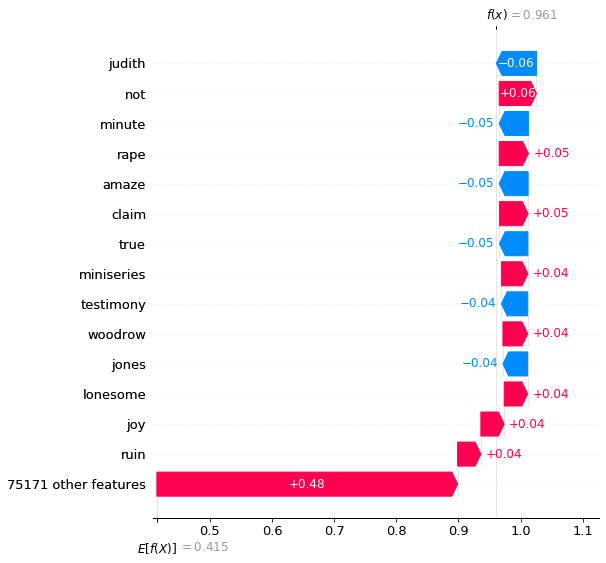

In [15]:
#WATERFALL PLOT
#shap.plots.waterfall(shap_values)
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       shap_values[0],
                                       feature_names=vocabulary, 
                                       max_display=15)

### > > Example 2: explain review 2 < <

#### Take a random review from test data set - - - > idx = 111

In [16]:
# Choose a random single sample idx = 
print('Random single sample (idx 111):')
idx = 111
ls_X_test = list(X_test)
ls_X_test[idx]

Random single sample (idx 111):


'look forward watch film since love david lynch version first attempt watch fell asleep nothing happen next night try watch rest put sleep nothing ever happen movie could keep anyone interest alive time get bit excite try fast forward dvd come second disk contain bonus material needle say no hard go torture watch dune low point act bad plot move slow motion set look cheap direction pathetic cgi visual effect childish want watch dune save money rent version'

#### Real class of given review

In [17]:
# the real category of this random sample selected from test dataset
# 1: Positive & 0: Negative
print('Random single sample (idx 111) belongs to class:', end = " ")
y_test[idx]
if y_test[idx] == 1:
    print('Positive')
else:
    print('Negative')

Random single sample (idx 111) belongs to class: Negative


#### Class predicted by NN for the given review

In [18]:
# output of the NN
print('NN Prediction for sample (idx 111):')
output = nn_propability_fn(ls_X_test[idx])

NN Prediction for sample (idx 111):
** [prediction_neg, prediction_pos] **
[0.9970332428347319, 0.0029667572]


#### Explain the sample's prediction

In [19]:
# Get sample 2 and transform it into TFID format
test_sample2 = sampleToTFIDF(ls_X_test[idx])
test_sample2 = test_sample2.toarray()

In [20]:
#Calculate SHAP values for the sample 2
shap_values = explainer.shap_values(test_sample2)

In [21]:
#FORCE PLOT
#shap.force_plot(explainer.expected_value, shap_values[0], test_sample2, feature_names = vocabulary)

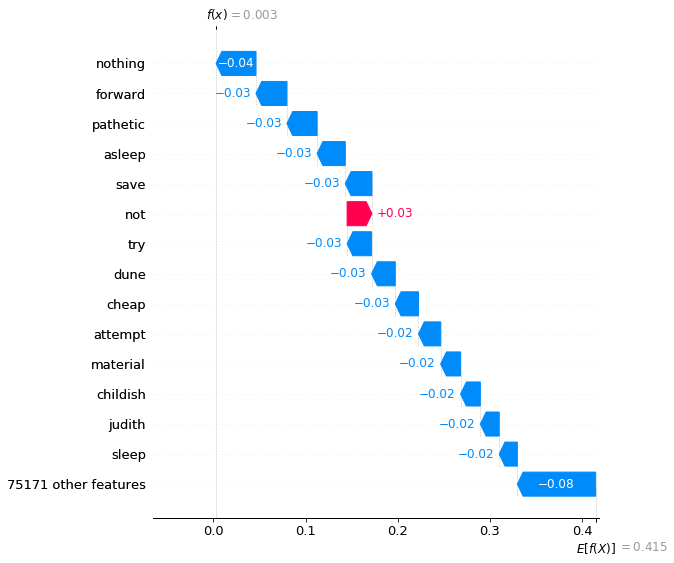

In [22]:
#WATERFALL PLOT
#shap.plots.waterfall(shap_values)
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       shap_values[0][0],
                                       feature_names=vocabulary, 
                                       max_display=15)